# Data

In [17]:
import pandas as pd
import numpy as np
import random

def modificar_dataframe(df, pct_filas = 0.1, pct_cambio = 0.2):
    # Número de filas y columnas del DataFrame
    num_filas = len(df)
    num_columnas = len(df.columns[1:-1]) # Para eliminar la primera y ultima columna (timestamp y label)
    
    # Seleccionar aleatoriamente el 10% de las filas
    num_filas_modificar = int(num_filas * pct_filas)
    filas_modificar = np.random.choice(df.index, size=num_filas_modificar, replace=False)
    
    # Seleccionar aleatoriamente un número de columnas (entre 1 y el número total de columnas)
    num_columnas_modificar = np.random.randint(1, num_columnas + 1)
    columnas_modificar = np.random.choice(df.columns[1:-1], size=num_columnas_modificar, replace=False)

    # Modificar los valores de las filas y columnas seleccionadas en un 15%
    for fila in filas_modificar:
        for columna in columnas_modificar:
            df.at[fila, columna] = int(df.at[fila, columna] * (1 + pct_cambio * random.uniform(1, 1.5)))
            df.at[fila, 'label'] = 1

    df.to_csv('tmp.csv')
            
    return df

def vicomtech_data(pct_cambio, pct_filas = 0.05, columns = []):
    dataframe = pd.read_csv('/home/nics/Repos/5G-Tactile-IDS/data/RecFile_1_20240712_095926_CAM_Generator_output_list.csv')
    dataframe = dataframe.drop('Unnamed: 0', axis=1)
    if len(columns) > 0:
        columns = ['Timestamp (UNIX) '] + columns
        dataframe = dataframe[columns]
    dataframe['label'] = 0
    # dataframe = dataframe.drop('Timestamp (UNIX) ', axis=1)

    modificar_dataframe(dataframe, pct_filas=pct_filas, pct_cambio=pct_cambio)

    return dataframe

# Scoring

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

def evaluate(Y, Y_pred):

    roc_auc = roc_auc_score(Y, Y_pred)
    print(f'ROC: {roc_auc}')

    # Compute confusion matrix
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# Classic Threshold

In [71]:
import pandas as pd
import numpy as np

def run_classic_threshold(df):
    idf = df

    comparing_df = idf.shift(-1) / idf
    comparing_df = comparing_df[:-1]

    pred_anomalies = ((comparing_df > 1.1) | (comparing_df < 0.9)).any(axis=1).astype(int).values
    pred_anomalies = np.append(pred_anomalies, [0])

    return pred_anomalies

# IForest

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def run_iforest(df):
    idf = df
    # Aplicar Isolation Forest
    model = IsolationForest(contamination=0.03)  
    idf['anomaly'] = model.fit_predict(idf)
    
    pred_labels = idf['anomaly'].apply(lambda x: 0 if x == 1 else 1)

    return pred_labels.to_numpy()

# evaluate(idf['label'], predictions_all['IForest'])

# LOF

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

def run_LOF(df):
    idf = df
    # Ajustar el modelo LOF
    model = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
    idf['anomaly_lof'] = model.fit_predict(idf)

    pred_labels = idf['anomaly_lof'].apply(lambda x: 0 if x == 1 else 1)

    return pred_labels.to_numpy()

# Autoencoder 1

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pyod.utils.data import evaluate_print

# Definir el modelo autoencoder multivariante
def crear_autoencoder_multivariante(dim_entrada):
    entrada = layers.Input(shape=(dim_entrada,))

    # Encoder with batch normalization
    codificador = layers.Dense(64, activation='relu')(entrada)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dense(32, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)

    # Decoder with batch normalization
    decodificador = layers.Dense(32, activation='relu')(codificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

    modelo = Model(entrada, decodificador)
    modelo.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    return modelo


def run_autoencoder_1(df):
    data = df

    columns = data.columns
    serie_temporal_multivariable = data[columns]

    # Normalizar la serie temporal multivariante
    serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()

    # Crear el modelo autoencoder multivariante
    dim_entrada = len(serie_normalizada.columns)
    modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

    # Entrenar el modelo autoencoder multivariante
    historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                                serie_normalizada.values, 
                                                epochs=25, 
                                                batch_size=64,
                                                verbose=0
                                                )

    # Umbral de reconstrucción
    umbral = np.percentile(historia.history['loss'], 99)
    print(f"Error: {umbral}")

    # Predicción de la serie temporal normalizada
    serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

    # Detección de anomalías
    anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

    # Info
    l1 = list(set(anomalias.index)) - anomalias.index[0]
    labels_pred = np.zeros(len(data))
    labels_pred[l1] = 1

    return labels_pred

2024-08-28 10:28:43.257686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 10:28:43.278967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 10:28:43.302725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 10:28:43.309743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 10:28:43.328107: I tensorflow/core/platform/cpu_feature_guar

# Autoencoder 2

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pyod.utils.data import evaluate_print

def crear_autoencoder_multivariante(dim_entrada):
    entrada = layers.Input(shape=(dim_entrada,))

    # Encoder with batch normalization and dropout
    codificador = layers.Dense(128, activation='relu')(entrada)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dropout(0.2)(codificador)
    codificador = layers.Dense(64, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)
    codificador = layers.Dense(32, activation='relu')(codificador)
    codificador = layers.BatchNormalization()(codificador)

    # Decoder with batch normalization and dropout
    decodificador = layers.Dense(32, activation='relu')(codificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dropout(0.2)(decodificador)
    decodificador = layers.Dense(64, activation='relu')(decodificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(128, activation='relu')(decodificador)
    decodificador = layers.BatchNormalization()(decodificador)
    decodificador = layers.Dense(dim_entrada, activation='linear')(decodificador)

    modelo = Model(entrada, decodificador)
    modelo.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    return modelo


def run_autoencoder_2(df):
    data = df

    columns = data.columns
    serie_temporal_multivariable = data[columns]

    # Normalizar la serie temporal multivariante
    serie_normalizada = (serie_temporal_multivariable - serie_temporal_multivariable.mean()) / serie_temporal_multivariable.std()
    # Definir el modelo autoencoder multivariante

    # Crear el modelo autoencoder multivariante
    dim_entrada = len(serie_normalizada.columns)
    modelo_autoencoder_multivariante = crear_autoencoder_multivariante(dim_entrada)

    # Entrenar el modelo autoencoder multivariante
    historia = modelo_autoencoder_multivariante.fit(serie_normalizada.values, 
                                                serie_normalizada.values, 
                                                epochs=25, 
                                                batch_size=64,
                                                verbose=0
                                                )

    # Umbral de reconstrucción
    umbral = np.percentile(historia.history['loss'], 99)
    print(f"Error: {umbral}")

    # Predicción de la serie temporal normalizada
    serie_reconstruida = modelo_autoencoder_multivariante.predict(serie_normalizada.values)

    # Detección de anomalías
    anomalias = serie_normalizada[np.linalg.norm(serie_normalizada.values - serie_reconstruida, axis=1) > umbral]

    # Info
    labels_pred = np.zeros(len(data))
    if len(anomalias > 0):
        l1 = list(set(anomalias.index)) - anomalias.index[0]
        labels_pred[l1] = 1

    return labels_pred

# Vote

In [8]:
def majority_vote(predictions):
    arrays = []
    for p in predictions:
        arrays.append(predictions[p])
    # Stack the arrays along a new dimension
    stacked_arrays = np.stack(arrays, axis=0)
    
    # Calculate the sum along the new dimension
    sum_arrays = np.sum(stacked_arrays, axis=0)
    
    # Determine the majority vote (more than half of the arrays should have a 1)
    majority_threshold = len(arrays) / 2
    
    # If the sum is greater than the threshold, the majority is 1, otherwise 0
    majority_vote_result = (sum_arrays >= majority_threshold).astype(int)
    
    return majority_vote_result

Error: 3.5830581092834466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 4.5012649917602525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.2798143386840817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.3709198284149164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 4.15445514678955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.6607108116149902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.511674432754516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 4.374926605224608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.5652680969238277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.233587703704833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.107002077102661
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.212333011627196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 2.803947048187256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.387465505599975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.3402123641967765
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.8015758991241446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.988077716827392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.1801237583160398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


Error: 3.331615514755249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
ROC: 0.6526315789473683


/home/nics/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


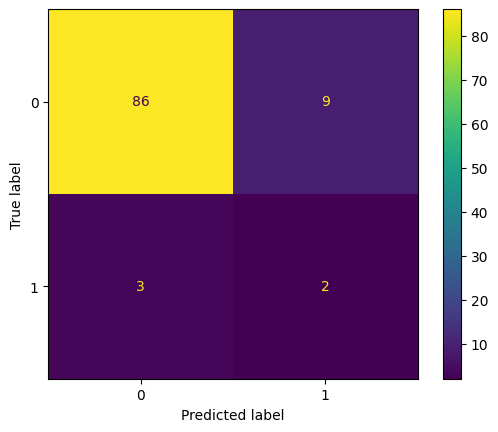

In [10]:
df = vicomtech_data(pct_cambio = 2, pct_filas = 0.03)
X = df.loc[:, df.columns != 'label']
# X.drop(columns=['Longitudinal acceleration', 'Curvature value'])

predictions_all = {}

cont = 0
vote = []
values_count = 100
while cont < values_count:
    data = X.iloc[cont:cont+5]
    cont += 5

    predictions_all['IForest'] = list(run_iforest(data.copy()))
    # predictions_all['Autoencoder1'] = list(run_autoencoder_1(data.copy()))
    predictions_all['Autoencoder2'] = list(run_autoencoder_2(data.copy()))
    predictions_all['LOF'] = list(run_LOF(data.copy()))
    # predictions_all['Classic_Threshold'] = list(run_classic_threshold(data.copy()))
    vote += list(majority_vote(predictions_all))
    # print(sum(vote))

evaluate(df['label'].head(values_count), vote)

## Stadistics depending on change %

In [ ]:
roc_auc_array = []
changes = [0.8, 1, 1.5, 2, 2.5, 3]
for change in changes:
    df = vicomtech_data(pct_cambio = change, pct_filas = 0.03)
    X = df.loc[:, df.columns != 'label']
    # X.drop(columns=['Longitudinal acceleration', 'Curvature value'])

    predictions_all = {}

    cont = 0
    vote = []
    values_count = 100
    while cont < values_count:
        data = X.iloc[cont:cont+100]
        cont += 100

        predictions_all['IForest'] = list(run_iforest(data.copy()))
        # predictions_all['Autoencoder1'] = list(run_autoencoder_1(data.copy()))
        predictions_all['Autoencoder2'] = list(run_autoencoder_2(data.copy()))
        predictions_all['LOF'] = list(run_LOF(data.copy()))
        # predictions_all['Classic_Threshold'] = list(run_classic_threshold(data.copy()))
        vote += list(majority_vote(predictions_all))

    roc_auc_array.append(roc_auc_score(df['label'].head(values_count), vote))

Error: 2.700228404998779
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Error: 2.919153261184692
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Error: 2.7386638736724853
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Error: 2.83237434387207
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Error: 2.8424112796783447
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Error: 2.794999284744262
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Error: 2.4794340705871583
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Error: 2.6142411994934083
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Error: 2.9023388481140135
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Error: 2.68788969039917
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Error: 2.9008659172058104
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Error: 2.8593493270874024
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Error: 2.8641311359405517
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Error: 3.2263788795471187
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Error: 2.8430503940582277
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Error: 3.0031507205963135
4/4 ━━━━━━━━━━━━━━━━━

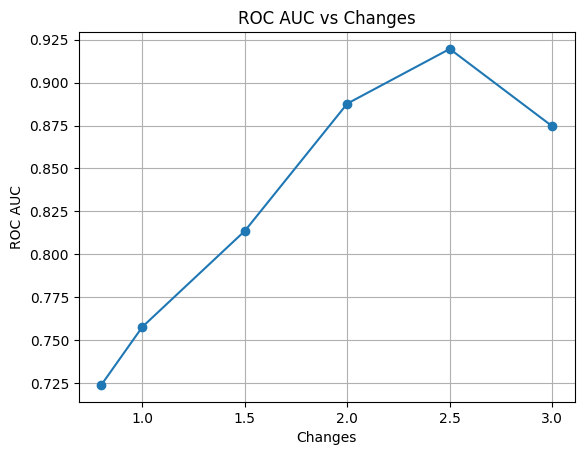

In [ ]:
#Plot
# Crear el gráfico
plt.plot(changes, roc_auc_array, marker='o')

# Etiquetas de los ejes
plt.xlabel('Changes')
plt.ylabel('ROC AUC')

# Título del gráfico
plt.title('ROC AUC vs Changes')

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()



# Only Speed

ROC: 0.960511767493287


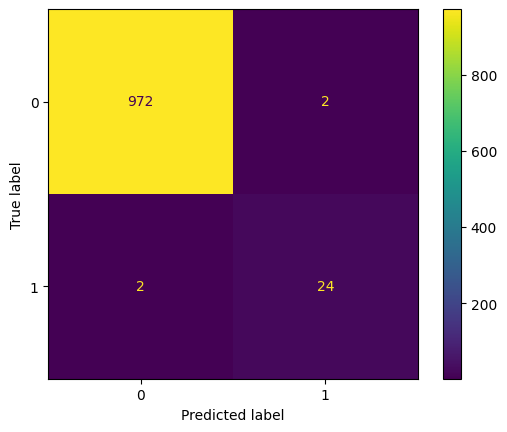

In [83]:
df = vicomtech_data(pct_cambio = 1, pct_filas = 0.03, columns=['Speed (cm/s)'])
X = df.loc[:, df.columns != 'label']

predictions_all = {}

cont = 0
vote = []
values_count = 1000
while cont < values_count:
    data = X.iloc[cont:cont+100]
    cont += 100

    predictions_all['IForest'] = list(run_iforest(data.copy()))
    # predictions_all['Autoencoder1'] = list(run_autoencoder_1(data.copy()))
    # predictions_all['Autoencoder2'] = list(run_autoencoder_2(data.copy()))
    predictions_all['LOF'] = list(run_LOF(data.copy()))
    predictions_all['Classic_Threshold'] = list(run_classic_threshold(data.copy()))
    vote += list(majority_vote(predictions_all))
    # print(sum(vote))

evaluate(df['label'].head(values_count), vote)

# Individual columns

In [102]:
def detect_anomalies_by_columnn(X):
    vote_all = {}

    for column in df.columns[1:-1]:
        print(column)
        predictions_all = {}

        cont = 0
        vote = []
        values_count = 1000
        while cont < values_count:
            data = X[[X.columns[1], column]].iloc[cont:cont+100]
            cont += 100

            predictions_all['IForest'] = list(run_iforest(data.copy()))
            # predictions_all['Autoencoder1'] = list(run_autoencoder_1(data.copy()))
            # predictions_all['Autoencoder2'] = list(run_autoencoder_2(data.copy()))
            predictions_all['LOF'] = list(run_LOF(data.copy()))
            predictions_all['Classic_Threshold'] = list(run_classic_threshold(data.copy()))
            vote += list(majority_vote(predictions_all))
        vote_all[column] = vote

    # Initialize the result with the first array
    result = vote_all[next(iter(vote_all))]

    # Perform AND operation across all arrays
    for array in vote_all.values():
        result = [x | y for x, y in zip(result, array)]
    
    return result


In [ ]:
df = vicomtech_data(pct_cambio = .5, pct_filas = 0.03)
X = df.loc[:, df.columns != 'label']
result = detect_anomalies_by_columnn(X)
evaluate(df['label'].head(values_count), result)

## Stadisitics depending on change %

In [116]:
roc_auc_array = []
changes = [0.1, 0.3, 0.6, 0.75, 1, 2, 2.5]
for change in changes:
    print(f'Change {change*100}%')
    df = vicomtech_data(pct_cambio = change, pct_filas = 0.03)
    X = df.loc[:, df.columns != 'label']
    result = detect_anomalies_by_columnn(X)

    roc_auc_array.append(roc_auc_score(df['label'].head(values_count), result))

Change 10.0%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 30.0%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 60.0%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 75.0%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 100%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 200%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value
Change 250.0%
Generation Delta Time
Latitude
Longitude
Altitude
Heading Value
Speed (cm/s)
Longitudinal acceleration
Curvature value


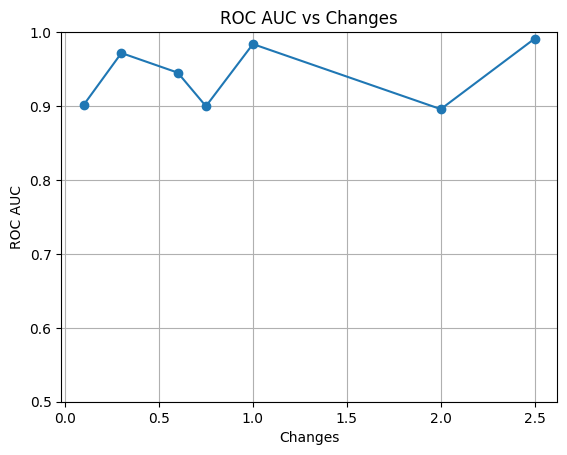

In [117]:
#Plot
# Crear el gráfico
plt.plot(changes, roc_auc_array, marker='o')

# Etiquetas de los ejes
plt.xlabel('Changes')
plt.ylabel('ROC AUC')

plt.ylim(0.5, 1.0)

# Título del gráfico
plt.title('ROC AUC vs Changes')

# Mostrar la cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()



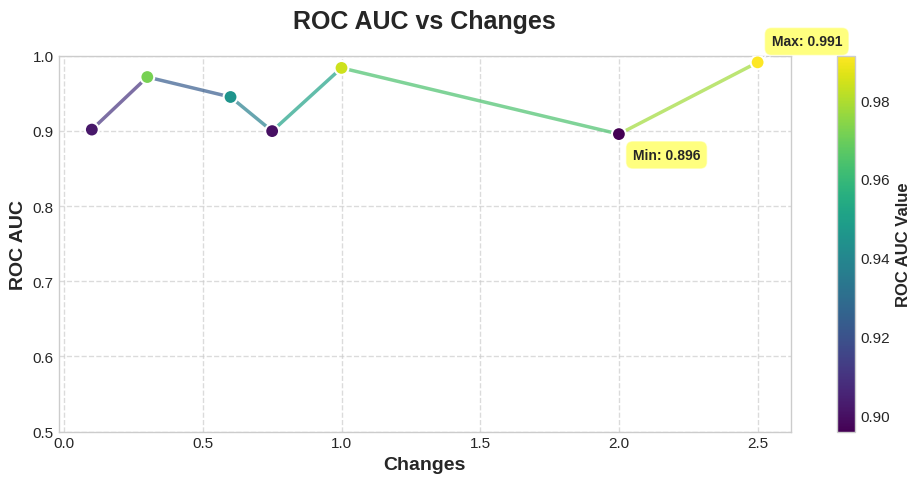

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style and color palette
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data with a gradient line
num_points = len(changes)
for i in range(1, num_points):
    ax.plot(changes[i-1:i+1], roc_auc_array[i-1:i+1], 
            color=plt.cm.viridis(i/num_points), linewidth=2.5, alpha=0.7)

# Add scatter points
scatter = ax.scatter(changes, roc_auc_array, s=100, c=roc_auc_array, cmap='viridis', 
                     edgecolor='white', linewidth=1.5, zorder=5)

# Customize the plot
ax.set_xlabel('Changes', fontsize=14, fontweight='bold')
ax.set_ylabel('ROC AUC', fontsize=14, fontweight='bold')
ax.set_ylim(0.5, 1.0)
ax.set_title('ROC AUC vs Changes', fontsize=18, fontweight='bold', pad=20)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('ROC AUC Value', fontsize=12, fontweight='bold')

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add annotations for min and max points
min_idx = np.argmin(roc_auc_array)
max_idx = np.argmax(roc_auc_array)

ax.annotate(f'Min: {roc_auc_array[min_idx]:.3f}', 
            xy=(changes[min_idx], roc_auc_array[min_idx]),
            xytext=(10, -10), textcoords='offset points',
            ha='left', va='top', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax.annotate(f'Max: {roc_auc_array[max_idx]:.3f}', 
            xy=(changes[max_idx], roc_auc_array[max_idx]),
            xytext=(10, 10), textcoords='offset points',
            ha='left', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()